In [1]:
from gerrychain import Graph

In [2]:
# Read Iowa county graph from the json file "IA_county.json"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
k = 4          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 789617 and U = 805568 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-14


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1716 rows, 1458 columns and 6990 nonzeros
Model fingerprint: 0x7e1cc4bc
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.02s
Presolved: 1716 rows, 1458 columns, 6990 nonzeros
Variable types: 444 continuous, 1014 integer (1014 binary)

Root relaxation: objective 0.000000e+00, 751 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  412          -    0.00000      -     -    0s
     0     0    0.09

In [11]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 32.0
District 0 has population 792030 and contains counties ['Wright', 'Montgomery', 'Union', 'Sac', 'Audubon', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Decatur', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Madison', 'Palo Alto', 'Ringgold', 'Calhoun', 'Clarke', 'Warren', 'Adair', 'Hancock', 'Shelby', 'Wayne', 'Dickinson', 'Buena Vista', 'Mills']

District 1 has population 799372 and contains counties ['Story', 'Polk', 'Marshall', 'Hardin', 'Boone', 'Hamilton', 'Franklin', 'Dallas']

District 2 has population 796787 and contains counties ['Keokuk', 'Davis', 'Jasper', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Monroe', 'Muscatine', 'Lucas', 'Washington', 'Cedar', 'Jefferson', 'Clinton', 'Poweshiek', 'Marion', 'Mahaska', 'Appanoose',

In [12]:
# To solve the MIP faster, let's fix some district roots:

r[8,1].LB = 1  # Fix Polk County as root of district 0
r[88,3].LB = 1 # Fix Linn County as root of district 1
r[25,2].LB = 1  # Fix Scott County as root of district 2

m.reset()      # Force Gurobi to start solving 'from scratch'
m.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1716 rows, 1458 columns and 6990 nonzeros
Model fingerprint: 0xcd001ad1
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 366 rows and 327 columns
Presolve time: 0.02s
Presolved: 1350 rows, 1131 columns, 5574 nonzeros
Variable types: 444 continuous, 687 integer (687 binary)

Root relaxation: objective 1.179866e+01, 1057 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.79866

In [13]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 32.0
District 0 has population 791695 and contains counties ['Wright', 'Montgomery', 'Union', 'Sac', 'Audubon', 'Hardin', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Cerro Gordo', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', 'Hamilton', 'Franklin', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Palo Alto', 'Ringgold', 'Calhoun', 'Worth', 'Adair', 'Hancock', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills']

District 1 has population 795249 and contains counties ['Story', 'Polk', 'Marshall', 'Boone', 'Jasper', 'Dallas']

District 2 has population 805355 and contains counties ['Keokuk', 'Davis', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Monroe', 'Muscatine', 'Lucas', 'Washington', 'Decatur', 'Cedar', 'Jefferson', 'Madison', 'Clarke', 'Warren', 'Poweshiek', 'Wayne', 'Marion', 'Mahaska',

In [14]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
# Read Iowa county shapefile from "IA_county.shp"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

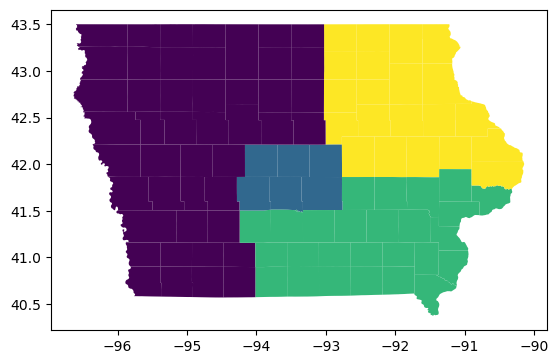

In [17]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()